<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_Regularizaci%C3%B3n_L1_y_L2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. Carga, Transformación (p >> n) y Preprocesamiento ---
Dataset final cargado con 65 características (columnas) y 442 muestras (filas).
--------------------------------------------------
--- 2. Resultados de Entrenamiento ---
Características originales: 10. Características expandidas: 65
Características ELIMINADAS por Lasso (Coeficiente ≈ 0): 52 de 65
--------------------------------------------------


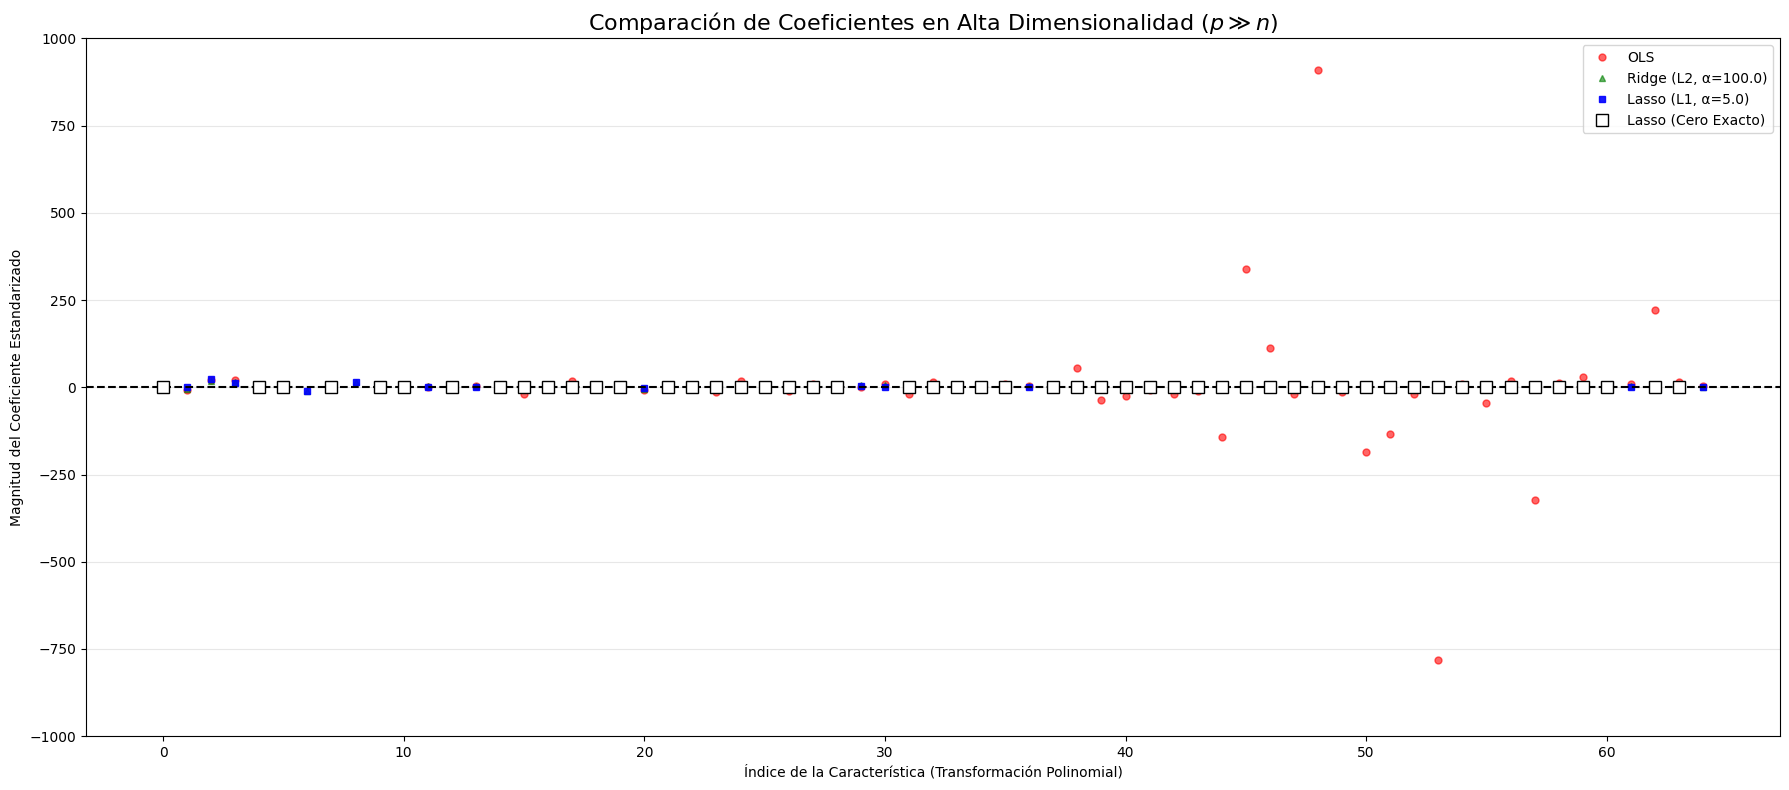

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import load_diabetes
import pandas as pd

# ----------------------------------------------------------------------
# 1. CARGA DE DATOS, TRANSFORMACIÓN POLINOMIAL Y PREPROCESAMIENTO
# ----------------------------------------------------------------------

print("--- 1. Carga, Transformación (p >> n) y Preprocesamiento ---")

# Cargar el dataset de Diabetes
diabetes = load_diabetes(as_frame=True)
X_original = diabetes.data
y = diabetes.target
original_feature_names = diabetes.feature_names

# Generar características polinomiales (Grado 2)
# Esto aumenta las 10 características a 65 (1 + 10 + 10*9/2 = 66, el bias es una)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_original)
feature_names = poly.get_feature_names_out(original_feature_names)
X = pd.DataFrame(X_poly, columns=feature_names)

# Estandarización de las características (CRUCIAL)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Dataset final cargado con {X.shape[1]} características (columnas) y {X.shape[0]} muestras (filas).")
print("-" * 50)


# ----------------------------------------------------------------------
# 2. ENTRENAMIENTO Y DEMOSTRACIÓN DEL EFECTO DE REGULARIZACIÓN
# ----------------------------------------------------------------------

# Definición de parámetros de regularización (ajustados para este dataset)
ALPHA_RIDGE = 100.0  # Penalización fuerte para controlar la multicolinealidad
ALPHA_LASSO = 5.0    # Penalización fuerte para forzar la eliminación

# Entrenamiento de los modelos
# OLS fallará por la alta dimensión y multicolinealidad
ols = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=ALPHA_RIDGE).fit(X_train, y_train)
lasso = Lasso(alpha=ALPHA_LASSO, max_iter=5000).fit(X_train, y_train) # Aumentamos iteraciones para convergencia

# Coeficientes
coef_ols = ols.coef_
coef_ridge = ridge.coef_
coef_lasso = lasso.coef_

# Contar cuántos coeficientes Lasso llevó a CERO
zeros_lasso = np.sum(np.abs(coef_lasso) < 1e-4)

print("--- 2. Resultados de Entrenamiento ---")
print(f"Características originales: 10. Características expandidas: {X.shape[1]}")
print(f"Características ELIMINADAS por Lasso (Coeficiente ≈ 0): {zeros_lasso} de {len(coef_lasso)}")
print("-" * 50)


# ----------------------------------------------------------------------
# 3. VISUALIZACIÓN CLAVE: OLS EXPLOSIVO vs. LASSO DISPERSO
# ----------------------------------------------------------------------

X_axis = np.arange(len(feature_names))

plt.figure(figsize=(18, 8))

# OLS: Verán valores muy altos y bajos (Inestabilidad)
plt.plot(X_axis, coef_ols, 'o', label='OLS', color='red', alpha=0.6, markersize=5)

# Ridge: Coeficientes reducidos pero todos NO CERO
plt.plot(X_axis, coef_ridge, '^', label=f'Ridge (L2, α={ALPHA_RIDGE})', color='green', alpha=0.6, markersize=5)

# Lasso: Coeficientes dispersos, muchos CERO EXACTO
plt.plot(X_axis, coef_lasso, 's', label=f'Lasso (L1, α={ALPHA_LASSO})', color='blue', alpha=0.9, markersize=5)

# Resaltar los coeficientes que Lasso ha eliminado (CERO EXACTO)
zero_indices = np.where(np.abs(coef_lasso) < 1e-4)[0]
plt.plot(zero_indices, coef_lasso[zero_indices], 's', markerfacecolor='white',
         markeredgecolor='black', markersize=8, zorder=5, label='Lasso (Cero Exacto)')

# Configuración del gráfico
plt.axhline(0, color='black', linestyle='--')
plt.title(r'Comparación de Coeficientes en Alta Dimensionalidad ($p \gg n$)', fontsize=16)
plt.xlabel('Índice de la Característica (Transformación Polinomial)')
plt.ylabel('Magnitud del Coeficiente Estandarizado')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.ylim(-1000, 1000) # Establecer límites grandes para contener la explosión de OLS
plt.tight_layout()
plt.show()